# Intel Cervical Cancer Screening
### April 21, 2017
## Satchel Grant

### Overview
This pipeline was made for the [Intel and MobileODT Cervical Cancer Screening](https://www.kaggle.com/c/intel-mobileodt-cervical-cancer-screening) competition on [Kaggle](https://www.kaggle.com/). The goal is to classify cervix images into 1 of 3 types of cervix. This assists in early detection and treatment of cancer.

This notebook shows several different convolutional neural network approaches.

The bulk of the Python code used to make this notebook is stored in seperate .py files distributed throughout the project folder. I will provide a link to appropriate files when using a function that is defined elsewhere in the project.



### Initial Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Internal Imports
from utilities import inout
from utilities import image_manipulation as imanip
from utilities import miscellaneous as misc

%matplotlib inline

## Preprocessing

### Read Paths

The images are stored as jpg files in seperate folders depending on their classification. I use the function [read_paths()](./utilities/inout.py) (`utilities.inout.py` line 14) to read in the image paths as strings. The function uses the image's folder name to get the corresponding label and returns the image paths and labels as two parallel arrays.

These lists will later be used in a generator to read in the images into numpy arrays. It would be easier from a coding perspective to read all the images into memory as numpy arrays, but the size of the dataset is too large for the RAM space.


In [ ]:
from itertools import count
import os

The training images are assumed to stored in the 'train' folder with subfolders 'Type_1', 'Type_2', 'Type_3'. The extra training images are assumed to be stored in a folder named 'extra_train' with subfolders 'Type_1', 'Type_2', 'Type_3'.

In [ ]:
# Read in file paths of images to be resized
image_paths = []
labels = []
training_folders = ['train', 'extra']
for folder in training_folders:
    new_paths, new_labels, n_classes = inout.read_paths(folder)
    if len(new_paths) > 0:
        image_paths += new_paths
        labels += new_labels


In [ ]:
image_paths, labels = shuffle(image_paths, labels)
histogram_dict = misc.histdict(labels, n_classes)

type1_count = histogram_dict[0]
type2_count = histogram_dict[1]
type3_count = histogram_dict[2]

print("Number of Type 1 Images:", type1_count)
print("Number of Type 2 Images:", type2_count)
print("Number of Type 3 Images:", type3_count)
print("Total Number of data samples: " + str(len(image_paths)))
print("Number of Classes: " + str(n_labels))

### Resizing
The images come from various sources and are of varying sizes. Additionally, some of the image data has been corrupted.

Neural networks need the image size to be constant. Another consideration is that the images need to be small enough so as to leave RAM space for the model to train, but large enough that important characteristics are distinguishable for classification. I semi-arbitrarily chose 256X256 px for the image size for my model. The reason was that 200-300 X 200-300 px are common image sizes for ImageNet models. I figured that if results were terrible, it would be easy to try a different size image.

I do the resizing using the [resize()](./utilities/image_manipulation.py) function (`utilities.image_manipulation.py` line 18). This function resizes the images while maintaining their aspect ratio. It then fills any black space with random color values.

I first tried resizing the images without maintaining the aspect ratio. This gave poor results. Maintaining the aspect ratio gave better results.

In the resize function, there is the option to save a mirrored version of the resized image. This can be used to boost the number of images for a specific cervix type. Given the relative distribution of data, I choose to add mirrored versions of images that fall into cervical types 1 and 3. This helps equalize the dataset.

In [ ]:
# Resize and save images to same name in dest_folder
# If of Cervix type 1 or 3, a mirrored image is additionally saved
for i,path,label in zip(count(),image_paths,labels):
    split_path = path.split('/')
    new_path = 'size'+str(new_img_shape[0])+'_'+split_path[-1]
    new_path = '/'.join([dest_folder]+split_path[:-1]+[new_path])
    add_flip = True
    if label == 1:
        add_flip = False

    # Used to exclude corrupt data
    try:
        imanip.resize(path, maxsizes=new_img_shape,
                            save_path=new_path,
                            add_flip=add_flip)
    except OSError:
        print("Error at path " + path)


### Training/Validation Split

I seperate the training data into two groups. One if for actually training the model, the other is to track how well the model is doing. It is important to validate the model with data that has not been used for training so that you can tell if your model is overfitting or underfitting the data. Differences in the training and validation accuracy can indicate the degree to which the model is overfitting or underfitting. This information can be used to decide when and how much dropout or regularization to use. It can also indicate when to stop training.

I portion 80% of the data for training and the other 20% for validation. After splitting the data, I save the paths and labels to csvs denoting when dataset they belong to. This insures that the two dataset do not get mixed after being established. This in turn gives flexibility to the training process. Models can be trained intermittently on multiple machines.

The training files are saved to `train_csv` and the validation are saved to `valid_csv`. The file type should be a `.csv`. The actual saving is done through the [save_paths()](./utilities/inout.py) function (`utilities.inout.py` line 48).


In [ ]:
train_csv = 'train_set.csv'
valid_csv = 'valid_set.csv'

training_portion = .8
split_index = int(training_portion*len(image_paths))
X_train_paths, y_train = image_paths[:split_index], labels[:split_index]
X_valid_paths, y_valid = image_paths[split_index:], labels[split_index:]

print("Train size: ")
print(len(X_train_paths))
print("Valid size: ")
print(len(X_valid_paths))

inout.save_paths(train_csv, X_train_paths, y_train)
inout.save_paths(valid_csv, X_valid_paths, y_valid)


### Read In Split Sets

The following cell is used if returning to this notebook after already seperating the data into training and validation sets. The paths and labels for the datasets are read in from the desired csv files using [get_split_data()](./utilities/inout.py) (`utilities.inout.py` line 76).

In [ ]:
X_train_paths, y_train = inout.get_split_data(training_csv)
X_valid_paths, y_valid = inout.get_split_data(valid_csv)
n_classes = max(y_train)+1

### Viewing the Images
The following cell shows what some of the images look like. Due to the graphic nature of the images, I left the format in float32 instead of uint8 so that the coloring is less intrusive.

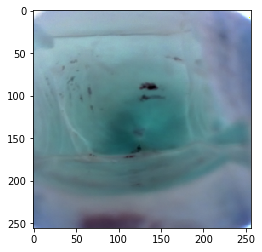

[ 0.  0.  1.]


/Users/satchelgrant/miniconda3/envs/obama/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


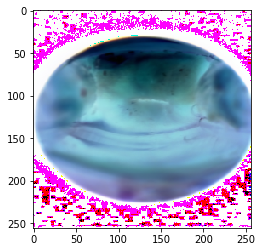

[ 0.  0.  1.]


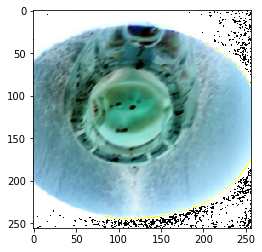

[ 0.  1.  0.]


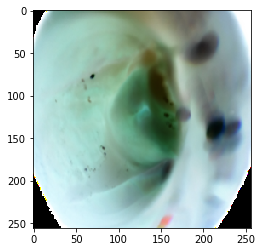

[ 0.  1.  0.]


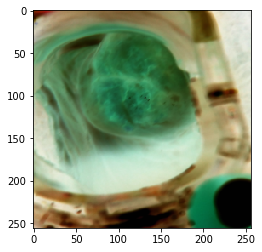

[ 0.  0.  1.]


In [89]:
image_gen = image_generator(X_train_paths[:10], y_train[:10], 2,randomly_augment=True)

for i in range(5):
    imgs, labels = next(image_gen)
    imgs = imgs
    show(imgs[0])
    print(labels[0])

### One Hot Encoding

The following cell converts the labels into one-hot vectors using [one_hot_encode()](./utilities/image_manipulation.py) (`utilities.image_manipulation.py` line 192).

One hot vectors represent the label of a data sample as a vector of zeros with a single 1. The index of the 1 value corresponds to the label. One-hot encoding is a useful representation of the truth labels because it is an easy format to produce from the neural net. This makes the loss easy to calculate and propagate backward.

In [ ]:
y_train = imanip.one_hot_encode(y_train, n_labels)
y_valid = imanip.one_hot_encode(y_valid, n_labels)

### Image Augmentations

The following cells are to demonstrate the types of image augmentations that are used to incease the effective size of the training data.

In [ ]:
demo_img = mpimg.imread(X_train_paths[0])
plt.imshow(demo_img)
plt.title('Unaltered Demo Image')
plt.show()

#### Rotations

The images are rotated using [rotate()](./utilities/image_manipulation.py) (`utilities.image_manipulation.py` line 67). The function rotates them by the specified angle and the resulting blank space is filled in with random pixel values.

I've been using the somewhat unfounded hypothesis that the classifier will be unaffected by image rotations up to 45 degrees. I initially thought that even a full 180 degree flip would have little affect, but 45 degrees seems less likely to cause problems while still giving a large degree of variability.

In [ ]:
rotation_angle = 45
aug_img = imanip.rotate(demo_img,rotation_angle)
plt.imshow(demo_img)
plt.title('Rotated Image')
plt.show()

#### Translations

The images are translated using the [translate()](./utilities/image_manipulation.py) function (`utilities.image_manipulation.py` line 87). The function translates each pixel in the image by the specified amount. Resulting blank space is filled with random pixel values.

It is important to prevent translations from cutting off important features in the image.

In [ ]:
row_displacement = 20
col_displacement = 20
aug_img = imanip.translate(demo_img,row_displacement,col_displacement)
plt.imshow(demo_img)
plt.title('Translated Image')
plt.show()

#### Scalings

The images are scaled using the [random_zoom()](./utilities/image_manipulation.py) function (`utilities.image_manipulation.py` line 119). The function randomly scales the image by the specified amount. Resulting blank space is filled with random pixel values.

It is important to prevent scalings from cutting off important features in the image and from reducing the resolution too low for important feature detection.

In [ ]:
max_zoom = 1/6
aug_img = imanip.random_zoom(demo_img,max_zoom)
plt.imshow(demo_img)
plt.title('Scaled Image')
plt.show()

### Image Generation

As stated earlier in the notebook, there are too many images to read them all into memory as numpy arrays. Instead, we can create a generator to read the images into memory in batches. This also gives us the opportunity to add random augmentations to effectively increase the size of our dataset.

The following cells create generators using the [image_generator()](./utilities/inout.py) function (`utilities.inout.py` line 193). An individual generator is made for both the training and validation sets. The generator for the training set adds randomly augmented images to the image batches. The random augmentations fall into one of the manipulation types demonstrated in the `Image Augmentations` section.

In [ ]:
add_random_augmentations = True
resize_dims = None


n_train_samples = len(X_train_paths)
train_steps_per_epoch = misc.get_steps(n_train_samples,batch_size,n_augs=1)

n_valid_samples = len(X_valid_paths)
valid_steps_per_epoch = misc.get_steps(n_valid_samples,batch_size,n_augs=0)

train_generator = inout.image_generator(X_train_paths,y_train,batch_size,
                                        resize_dims=resize_dims,
                                        randomly_augment=add_random_augmentations)
valid_generator = inout.image_generator(X_valid_paths, y_valid, batch_size, 
                                        resize_dims=resize_dims,rand_order=False)



### Training

This section demonstrates multiple trainings. The models are stored in the [models](./models) folder. The weights are stored in the [weights](./weights) folder.

The order of the batchnorm, maxpooling, and dropout has been an intersting experiment for this project. It is these sorts of choices, that can make model architecture more of an art than a science. The best model generalization has resulted from the order I just described. I have not developed a way to discover exactly why, but my hypothesis is as follows. 

Batch normalization uses the average of all activations in a layer to normalize the batch's layer of activations (hence 'batch normalization). With more activations in the normalization process, the less any one activation can dominate the normalization. Thus batchnorm should be more robust before the maxpooling.

Next, it is important to use dropout after maxpooling because the dropout will have a more intense affect. This is because the affects of dropout can potentially go unnoticed if done before a maxpooling layer. If values that will be excluded in the maxpooling process are dropped prior to the maxpooling, then the dropout has no affect. Thus to ensure the dropout has an impact on the next convolutional layer, it should be done after the maxpooling.

Again, I should note that I have not proved these ideas. This is just an attempt to explain empirical findings.

In [ ]:
from keras.models import Sequential, Model
from keras import optimizers
from keras.layers import Dense

#### First Model
This model is defined in the [cnn_model()](./models/model.py) function (`models.model.py` line 6) and has proven to be the best approach so far with an approximate 66% accuracy on the validation set. See the [README](./README.md) for a detailed diagram of the model layers.

The basic approach is to use a 3x3 and a 5x5 filter at each convolutional layer of the model followed by batchnorm, maxpooling, and dropout.

In [ ]:
from models import model as mod

In [ ]:
n_labels = 3
batch_size = 100
image_shape = (256,256,3)

first_conv_shapes = [(4,4),(3,3),(5,5)]
conv_shapes = [(3,3),(5,5)]
conv_depths = [12,12,11,8,8]
dense_shapes = [100,50,n_labels]

In [ ]:
inputs, outs = mod.cnn_model(first_conv_shapes, conv_shapes, conv_depths, dense_shapes, image_shape, n_labels)

model = Model(inputs=inputs,outputs=outs)

model.load_weights('./weights/cpu_model.h5')
learning_rate = .0001
for i in range(20):
    if i > 4:
        learning_rate = .00001 # Anneals the learning rate
    adam_opt = optimizers.Adam(lr=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=adam_opt, metrics=['accuracy'])
    history = model.fit_generator(train_generator, train_steps_per_epoch, epochs=1,
                        validation_data=valid_generator,validation_steps=valid_steps_per_epoch, max_q_size=1)
    model.save('./weights/cpu_model_update.h5')

#### Second Model

This model is defined in the [cnn_model_1x1()](./models/model.py) function (`models.model.py` line 44) and has proven to be the second best approach so far with an approximate 60% accuracy on the validation set. See the [README](./README.md) for a detailed diagram of the model layers.

The basic approach is to use a 1x1 filter prior to the 3x3 and a 5x5 filter at each convolutional layer of the model followed by batchnorm, maxpooling, and dropout. The leading 1x1 effectively allows for scaling of the activation depth. This allows the model to be built both wider and deeper without exceeding the limits of the RAM. The architecture for this model was heavily inspired by Google's inception models. 

I had high hopes for this style of model, and the training process is much quicker than without the 1x1 filter layers, but it has been difficult to prevent the model from overfitting. In attempt to solve this problem, I will continue to increase dropout, increase the training set size, implement pseudo labeling.

In [ ]:
from models import model as mod

In [ ]:
n_labels = 3
batch_size = 100
image_shape = (256,256,3)

ones_depth=25
conv_shapes=[(3,3),(5,5)]
conv_depths=[10,12,14,16,20]
dense_shapes=[200,70,3]
image_shape=(256,256,3)


In [ ]:
inputs, outs = mod.cnn_model_1x1(conv_shapes, conv_depths, dense_shapes, image_shape, n_labels,ones_depth)

model = Model(inputs=inputs,outputs=outs)

adam_opt = optimizers.Adam(lr=.0001)
for i in range(20):
    model.compile(loss='categorical_crossentropy', optimizer=adam_opt, metrics=['accuracy'])
    history = model.fit_generator(train_generator, train_steps_per_epoch, epochs=1,
                        validation_data=valid_generator,validation_steps=valid_steps_per_epoch, max_q_size=1)
    model.save('./weights/model_1x1.h5')


#### Transfer Model

_Note: The transfer learning cells will not work unless you have resized the images to 299x299x3_

Transfer learning is the process of repurposing a previously trained model. These models are made by smart people with lots of resources. It is easy to use pieces of their trained model as the backbone of a new model. 

Feature extraction and fine tuning are the two approaches in transfer learning. 

Feature extraction is the process of removing the output layer of the transfer model and training a new, small model (usually only dense layers) on the outputs. Thus no training occurs on the transferred model. 

Finetuning is the process of removing the output layer and appending layers to the model and then training the entire model.

I attempted both feature extraction and fine-tuning on Google's Inception V4 model. Both gave poor results. See the `Failed Experiments` section in the [README](./README.md) for a more detailed analysis.

This model is defined throughout the [inceptionV4.py](./models/model.py) file. The bulk of the code was taken from an outside source.


In [ ]:
from models import inceptionV4 as incept

In [ ]:
feature_extraction_only = False

init, flat_layer, weights = incept.create_inception_v4()
flat_layer = Dense(1001, activation='elu')(flat_layer)
outs = Dense(3, activation='elu')(flat_layer)

model = Model(inputs=init,outputs=outs)
model.load_weights(weights, by_name=True)

if feature_extraction_only:
    for i in range(len(model.layers[:-3])):
        model.layers[i].trainable = False

learning_rate = .0001
for i in range(20):
    if i > 4:
        learning_rate = .00001 # Anneals the learning rate
    adam_opt = optimizers.Adam(lr=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=adam_opt, metrics=['accuracy'])
    history = model.fit_generator(train_generator, train_steps_per_epoch, epochs=1,
                        validation_data=valid_generator,validation_steps=valid_steps_per_epoch, max_q_size=1)
    model.save('./weights/inception_model.h5')
print('History test', history.history)

### Predictions
The following cells make predictions on the test set.


In [ ]:
import time
from multiprocessing.pool import ThreadPool
from keras.models import Sequential, Model

In [ ]:
data_path = './test'
model_path = 'weights/gpu_model_update.h5'

resize_dims = (256,256,3)
test_divisions = 20 # Used for segmenting image evaluation in threading
batch_size = 100 # Batch size used for keras predict function

In [ ]:
ins, outs = mod.cnn_model()
model = Model(inputs=ins,outputs=outs)
model.load_weights(model_path)

In [ ]:
test_paths, test_labels, _ = inout.read_paths(data_path,no_labels=True)
print(str(len(test_paths))+' testing images')

In [ ]:
pool = ThreadPool(processes=1)
portion = len(test_paths)//test_divisions+1 # Number of images to read in per pool

async_result = pool.apply_async(inout.convert_images,(test_paths[0*portion:portion*(0+1)],
                                                test_labels[0*portion:portion*(0+1)],resize_dims))

In [ ]:
total_base_time = time.time()
test_imgs = []
predictions = []
for i in range(1,test_divisions+1):
    base_time = time.time()

    print("Begin set " + str(i))
    while len(test_imgs) == 0:
        test_imgs,_ = async_result.get()
    img_holder = test_imgs
    test_imgs = []

    if i < test_divisions:
        async_result = pool.apply_async(inout.convert_images,(test_paths[i*portion:portion*(i+1)],
                                                        test_labels[0*portion:portion*(0+1)],resize_dims))

    predictions.append(model.predict(img_holder,batch_size=batch_size,verbose=0))
    print("Execution Time: " + str((time.time()-base_time)/60)+'min\n')

predictions = np.concatenate(predictions, axis=0)
print("Total Execution Time: " + str((time.time()-total_base_time)/60)+'mins')


In [ ]:
conf = .95 # Prediction confidence
predictions = misc.confidence(predictions, conf)

In [ ]:
header = 'image_name,Type_1,Type_2,Type_3'
inout.save_predictions('submission.csv', test_labels, predictions, header)